In [616]:
!pip install contractions

In [617]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

file_path = '/content/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson'

# Load the ldjson dataset into a pandas DataFrame
amz_data = pd.read_json(file_path, lines=True)

In [618]:
# Shape of the dataset
print(f"This dataset has `{amz_data.shape[0]}` data points and has `{amz_data.shape[1]}` attributes.", end='\n\n')
# List of attributes in the dataset
print(f"Attributes in the dataset are {amz_data.columns}")

This dataset has `30000` data points and has `33` attributes.

Attributes in the dataset are Index(['uniq_id', 'crawl_timestamp', 'asin', 'product_url', 'product_name',
       'image_urls__small', 'medium', 'large', 'browsenode', 'brand',
       'sales_price', 'weight', 'rating', 'sales_rank_in_parent_category',
       'sales_rank_in_child_category', 'delivery_type', 'meta_keywords',
       'amazon_prime__y_or_n', 'parent___child_category__all',
       'best_seller_tag__y_or_n', 'other_items_customers_buy',
       'product_details__k_v_pairs', 'discount_percentage', 'colour',
       'no__of_reviews', 'seller_name', 'seller_id', 'left_in_stock',
       'no__of_offers', 'no__of_sellers', 'technical_details__k_v_pairs',
       'formats___editions', 'name_of_author_for_books'],
      dtype='object')


In [619]:
# Check for missing values
missing_values = amz_data.isnull().sum()
print(f"\nMissing values in the dataset \n {missing_values[missing_values > 0]}")
print(len(missing_values [missing_values > 0]))
# Out of 33 attributes, 22 attributes have definite missing values.


Missing values in the dataset 
 image_urls__small                    2
medium                               2
large                             1159
browsenode                         520
brand                             8143
sales_price                       2890
sales_rank_in_parent_category     4503
sales_rank_in_child_category      5149
parent___child_category__all      4503
other_items_customers_buy         5637
product_details__k_v_pairs        1183
discount_percentage              15376
colour                           23971
no__of_reviews                   26548
seller_name                      21636
seller_id                        21636
left_in_stock                    26943
no__of_offers                    28980
no__of_sellers                   28980
technical_details__k_v_pairs     28846
formats___editions               29998
name_of_author_for_books         29999
dtype: int64
22


In [620]:
# Selecting only the necessary columns that will be used to find_similar_products
features_to_use = ['uniq_id', 'brand', 'sales_price', 'weight', 'rating', 'colour', 'product_name']

# Extract those features_to_use columns and will create a copy to keep the original data intact
features  = amz_data[features_to_use].copy()

## Pre-processing

### Feature - Weight

In [621]:
# Clean the weight column and apply outlier filtering
# Helper function to pre-process the weight attribute of the dataset, since this attribute has two many issue like having strings,
# some values in grams, g, kg, Kg, kilograms, and 999999999.0, it needed to be processed into single form as numeric float
# with also making sure the outliers are taken care if any present
def clean_weight(w):
    try:
        w = str(w)  # Convert w to string before checking type
        # print(f"Original input: '{w}'")  # Print original input
        if isinstance(w, str):
            w = w.lower()
            # print(f"Lowercased: '{w}'")
            w = w.replace("kg", "*1000").replace("kilograms", "*1000")  # Remove kg/kilograms first
            # print(f"After removing kg units: '{w}'")
            w = w.replace("grams", "").replace("gram", "").replace("g", "")  # Remove gram units
            # print(f"After removing gram units: '{w}'")
            w = w.strip()  # Strip leading/trailing whitespace before eval
            # print(f"After strip: '{w}'")
            if "*" in w:
                w = eval(w)
                # print(f"After eval: '{w}'")
            return float(w) # Now w can be directly converted to float
        else:
            # print("Input is not a string")
            return np.nan
    except Exception as e:
        # print(f"Error: {e}")  # Print the specific error message
        return np.nan

In [622]:
features['weight'] = features['weight'].apply(clean_weight)

In [623]:
print(f"These many outlier we have in weight ", features[features['weight'] == 999999999]['weight'].count())
# One outlier that we have is in the weight attribute - 999999999.0
# This is an outlier and placeholder for unknown or missing weights. It's not a real measurement.
# And there are ~14376 entries with 999999999 out of 30000. While the actual weights are typically between 10g to 2kg.

# Option 1:If we drop these rows and treat it as misssing, Trade-off is we would be losing ~48% of data

# Option 2:What if we Replace with a proxy value (e.g., median of known weights), Neutralizing the noise without removing data
features['weight'] = features['weight'].replace(999999999, np.nan)
# features['weight'] = features['weight'].fillna(features['weight'].median())
# When going with option 2, Even after excluding 999999999, the count will be ~4,856 weights, with median ~249g, and max 136,000g = 136 kg extreme outlier
# So we have two problems, ~48% of Fake Values -> 999999999 as placeholders and Extreme real outliers → like 136000.0 are likely data entry errors or rare.
# So we Avoid letting bad values distort similarity calculations, and use a famour decision tree imputation technique


These many outlier we have in weight  23745


### Feature - Sales Price

In [624]:
features['sales_price'].isna().sum()

2890

In [625]:
# Converting sales_price to numeric values, ensuring all rows are in float for sales_price
# Any non-numeric or malformed entries (e.g., strings like 'NA' or '-') are coerced to NaN
features['sales_price'] = pd.to_numeric(features['sales_price'], errors='coerce')

# Here we impute missing sales_price values with the median
# Median is used instead of mean to reduce the impact of outliers
features['sales_price'] = features['sales_price'].fillna(features['sales_price'].median())

### Feature - Brand

In [626]:
features['brand'].value_counts()

,count
brand,
Max,504
Generic,245
BIBA,205
Mothercare,156
Campus Sutra,150
...,...
Majisha11,1
Bipolar Life,1
Tomfy,1


In [627]:
import string

# Fill the missing values with 'Unknown'
features['brand'] = features['brand'].fillna('unknown')

# Cleaning brand text (lowercase, remove punctuation, and strip whitespace)
def clean_brand(brand):
    brand = brand.lower()
    brand = brand.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    brand = brand.strip()
    return brand

features['brand'] = features['brand'].apply(clean_brand)


### Feature - Product name

In [628]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [629]:
# PreProcessing the product_name text column using NLTK + contractions
# We will use 'nltk' to remove common English words like the, is, and, which don't carry meaningful information
# Using nltk snowballstemmer to allow the model to treat similar words as the same, improving generalization and reducing dimensionality

import re
import string
import contractions
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm

# Load stopwords and initialize stemmer for both English
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

# Function to remove punctuation using the pre-defined function in python called string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to clean and process product titles
def clean_product_name(text):
    if pd.isna(text):
        return ""

    # Expand contractions like can't → cannot, using the library to take care of all possibility, to handle negatations
    text = contractions.fix(text)

    # Removing words with digits like  100ml, 2pack, etc..,
    text = re.sub(r'\S*\d\S*', '', text)

    # Remove all non-alphabetic characters
    text = re.sub('[^A-Za-z]+', ' ', text)

    # Tokenize, lowercase, remove stopwords, apply stemming to the words
    cleaned_words = [
        stemmer.stem(word.lower())
        for word in text.split()
        if word.lower() not in stop_words
    ]

    # Rejoin words and remove remaining punctuation
    return remove_punctuation(' '.join(cleaned_words)).strip()

tqdm.pandas(desc="Cleaning product_name")
features['product_name'] = features['product_name'].progress_apply(clean_product_name)


Cleaning product_name: 100%|██████████| 30000/30000 [00:12<00:00, 2423.33it/s]


In [630]:
features.head()

,uniq_id,brand,sales_price,weight,rating,colour,product_name
0,26d41bdc1495de290bc8e6062d927729,la facon,200.0,NaN,5.0,NaN,la facon cotton kalamkari handblock sare blous...
1,410c62298852e68f34c35560f2311e5a,unknown,265.0,NaN,3.6,NaN,sf jean pantaloon men plain slim fit shirt
2,52e31bb31680b0ec73de0d781a23cc0a,lovista,660.0,NaN,3.5,NaN,lovista cotton gota patti tassel tradit print ...
3,25798d6dc43239c118452d1bee0fb088,unknown,195.0,NaN,3.0,NaN,peopl men print regular fit shirt
4,ad8a5a196d515ef09dfdaf082bdc37c4,unknown,1914.0,NaN,5.0,NaN,mont carlo grey solid cotton blend polo collar...


In [631]:
features.shape

(30000, 7)

### Features imputation for weight attribute

In [632]:
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Select relevant features
features_list = ['brand', 'product_name', 'sales_price', 'rating']
df = features[features_list + ['weight']].copy()

# Encode 'brand' as numeric
le_brand = LabelEncoder()
df['brand_encoded'] = le_brand.fit_transform(df['brand'])

# TF-IDF for 'product_name'
tfidf = TfidfVectorizer(max_features=100)
text_features = tfidf.fit_transform(df['product_name'])
text_df = pd.DataFrame(text_features.toarray(), columns=tfidf.get_feature_names_out())

# Combine all features into X
X_full = pd.concat([df[['brand_encoded', 'sales_price', 'rating']].reset_index(drop=True), text_df], axis=1)

# Split into known and missing weights
known_mask = ~df['weight'].isna()
X_eval = X_full[known_mask]
y_eval = df.loc[known_mask, 'weight']

# Filter outliers
max_weight_threshold = 10000
mask = y_eval < max_weight_threshold
X_eval = X_eval[mask]
y_eval = y_eval[mask]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=0.2, random_state=42)


#### Decision Tree Regressor for Imputation

In [633]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
r2_tree = r2_score(y_test, y_pred_tree)
rmse_tree = math.sqrt(mean_squared_error(y_test, y_pred_tree))

print(f"Decision Tree R2 Score: {r2_tree:.4f}")
print(f"Decision Tree RMSE: {rmse_tree:.2f}")


Decision Tree R2 Score: 0.2125
Decision Tree RMSE: 140.47


#### Random Forest Regressor

In [634]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='log2', random_state=42)
forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)
r2_forest = r2_score(y_test, y_pred_forest)
rmse_forest = math.sqrt(mean_squared_error(y_test, y_pred_forest))

print(f"Random Forest R2 Score: {r2_forest:.4f}")
print(f"Random Forest RMSE: {rmse_forest:.2f}")

Random Forest R2 Score: 0.4615
Random Forest RMSE: 116.16


Decision trees often overfit on outliers, they can memorize those extreme values and appear to explain more variance means (higher R²)

Once we remove outliers, the tree has less "variance to explain", and it may overfit the remaining data poorly because it's just one tree.

**Even though Decision Tree has lower RMSE after filtering, it also fails to generalize well (low R²). This makes it less reliable for unseen data or for consistent imputation.**

So we go ahead with random forest regressor.

In [635]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Model
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)

# Run cross-validation using built-in RMSE scorer
rmse_scores = cross_val_score(model, X_eval, y_eval, scoring='neg_root_mean_squared_error', cv=kf)

# Print average RMSE across folds
print(f"Cross-validated RMSE: {-rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")


Cross-validated RMSE: 148.00 ± 23.91


In [636]:
# Retrain on ALL known weight data before imputation
forest_final = RandomForestRegressor(n_estimators=100, max_depth=None, max_features='log2', random_state=42)
forest_final.fit(X_eval, y_eval)

RandomForestRegressor(max_features='log2', random_state=42)

In [637]:
# Identify rows with missing weights
X_missing = X_full[~known_mask]

# Predict missing weights using the trained Random Forest
predicted_missing_weights = forest_final.predict(X_missing)

# Fill predicted weights back into the original features DataFrame
features.loc[~known_mask, 'weight'] = predicted_missing_weights

In [638]:
# remove weight that are above 4000
# Remove weights above 4000
features = features[features['weight'] <= 4000]

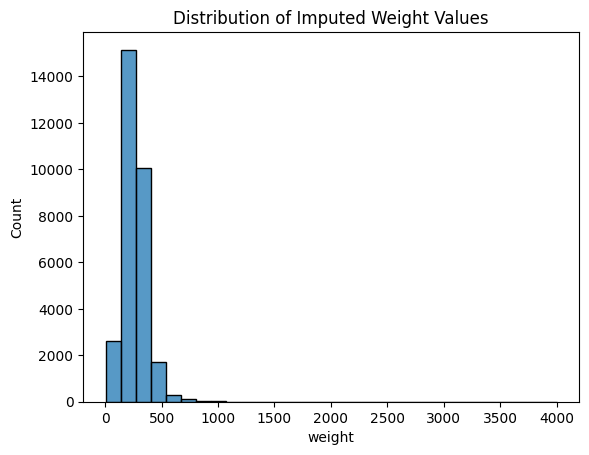

In [639]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(features['weight'], bins=30)
plt.title("Distribution of Imputed Weight Values")
plt.show()

In [640]:
features.describe(include='all')

,uniq_id,brand,sales_price,weight,rating,colour,product_name
count,29991,29991,29991.000000,29991.000000,29991.000000,6029,29991
unique,29991,6326,NaN,NaN,NaN,4757,21258
top,26d41bdc1495de290bc8e6062d927729,unknown,NaN,NaN,NaN,Black|White,max boy regular fit shirt
freq,1,8205,NaN,NaN,NaN,79,92
mean,NaN,NaN,835.308182,263.609955,4.039782,NaN,NaN
std,NaN,NaN,918.660334,108.617258,0.840081,NaN,NaN
min,NaN,NaN,39.000000,4.540000,1.000000,NaN,NaN
25%,NaN,NaN,399.000000,204.614850,3.500000,NaN,NaN
50%,NaN,NaN,590.000000,251.372800,4.000000,NaN,NaN
75%,NaN,NaN,849.000000,307.570000,4.900000,NaN,NaN


### Feature- colour

In [641]:
import re
# [black|organe]
def clean_color_string(c):
    if pd.isna(c):
        return []
    # Remove text inside parentheses
    c = re.sub(r'\([^)]*\)', '', c)
    # Replace + with |
    c = c.replace('+', '|')
    # Split and clean
    colors = [col.strip().lower() for col in c.split('|')]
    # Remove empty entries and deduplicate
    colors = list(set(filter(None, colors)))
    return colors

# Apply to your color column
features['colour_list'] = features['colour'].apply(clean_color_string)
print(features['colour_list'].sample(5))
print("Total unique cleaned colors:", len(set([color for sublist in features['colour_list'] for color in sublist])))

14397    []
112      []
27615    []
9611     []
20157    []
Name: colour_list, dtype: object
Total unique cleaned colors: 7543


In [642]:
# Drop the original 'colour' column
if 'colour' in features.columns:
    features.drop(columns=['colour'], inplace=True)

# Replace empty lists or NaN with 'unknown' in 'color_list' column
features['colour_list'] = features['colour_list'].apply(lambda x: ['unknown'] if (isinstance(x, list) and len(x) == 0) or (isinstance(x, float) and pd.isna(x)) else x)

### cleaning null-values with dropna

In [643]:
# Removing the duplicate product_name, this could lead an issue while getting similarity
print( sum(features.duplicated('product_name')))
features = features.drop_duplicates(subset=['product_name'])
print(features.shape)
features.head()
features.sort_values('product_name',inplace=True,ascending=False)

8733
(21258, 7)


<ipython-input-643-da5663460962>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.sort_values('product_name',inplace=True,ascending=False)


In [644]:
features.isna().sum()

,0
uniq_id,0
brand,0
sales_price,0
weight,0
rating,0
product_name,0
colour_list,0


In [645]:
# Drop any rows with missing critical values (redundant safeguard)
features.dropna(subset=['brand', 'sales_price', 'weight', 'rating'], inplace=True)

# Reset index
features.reset_index(drop=True, inplace=True)

<ipython-input-645-0f6023dda0ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(subset=['brand', 'sales_price', 'weight', 'rating'], inplace=True)


In [646]:
features.describe(include='all')

,uniq_id,brand,sales_price,weight,rating,product_name,colour_list
count,21258,21258,21258.000000,21258.000000,21258.000000,21258,21258
unique,21258,6319,NaN,NaN,NaN,21258,3683
top,24ab59522ee0ee7c1b009e568d504c0e,unknown,NaN,NaN,NaN,zysta stainless steel grid men classic shirt c...,[unknown]
freq,1,3566,NaN,NaN,NaN,1,16518
mean,NaN,NaN,903.736002,256.656955,4.059305,NaN,NaN
std,NaN,NaN,1028.880733,115.837383,0.857846,NaN,NaN
min,NaN,NaN,39.000000,4.540000,1.000000,NaN,NaN
25%,NaN,NaN,399.000000,200.000000,3.600000,NaN,NaN
50%,NaN,NaN,590.000000,249.000000,4.000000,NaN,NaN
75%,NaN,NaN,893.000000,302.506000,5.000000,NaN,NaN


## Similarity

In [647]:
# --- Product Name (TF-IDF) ---
from sklearn.feature_extraction.text import TfidfVectorizer # Import the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)
product_name_tfidf = tfidf_vectorizer.fit_transform(features['product_name'].fillna(""))

In [648]:
from sklearn.preprocessing import MultiLabelBinarizer

color_binarizer = MultiLabelBinarizer()
color_matrix = color_binarizer.fit_transform(features['colour_list'])

In [649]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

# Encode 'brand'
encoder = OneHotEncoder(handle_unknown='ignore')
brand_encoded = encoder.fit_transform(features[['brand']])

In [650]:
features.head()

,uniq_id,brand,sales_price,weight,rating,product_name,colour_list
0,24ab59522ee0ee7c1b009e568d504c0e,zysta,590.0,68.0000,5.0,zysta stainless steel grid men classic shirt c...,[unknown]
1,9ddb498a1a9acd7001454b4ab39ad0a0,zutano,4950.0,59.0000,4.8,zutano unisex babi fleec w furri babi booti pi...,[unknown]
2,76541b0d2d50e5962b20102ff03b1144,zutano,4770.0,90.7000,4.6,zutano toddler cozi fleec furri trapper hat na...,[unknown]
3,be2fc5ea4e9f25b14081183b3033bb52,zutano,4770.0,59.0000,5.0,zutano doubl layer fleec babi booti w gripper ...,[unknown]
4,e467fadfbc93ff6f6669025c80fd45e7,zutano,590.0,317.1877,4.2,zutano babi girl kitti kat pant,[unknown]


In [651]:
# Normalize numerical features
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(features[['sales_price', 'weight', 'rating']])

# Combine all into final feature matrix
feature_matrix = np.hstack([brand_encoded.toarray(), numeric_features])

# Map back to uniq_id for reverse lookup
uniq_ids = features['uniq_id'].tolist()


In [652]:
# Combine everything into one unified feature matrix
feature_matrix = np.hstack([
    brand_encoded.toarray(),                          # One-hot brand
    numeric_features,                       # price, weight, rating (scaled)
    product_name_tfidf.toarray(),           # semantic vector
    color_matrix                            # multi-hot color tags
])

In [653]:
from typing import List
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_products(product_id: str, num_similar: int) -> List[str]:
    if product_id not in uniq_ids:
        raise ValueError(f"Product ID {product_id} not found in cleaned dataset.")

    idx = uniq_ids.index(product_id)
    query_vector = feature_matrix[idx].reshape(1, -1)

    similarities = cosine_similarity(query_vector, feature_matrix).flatten()

    # Get top-N indices sorted by similarity
    top_indices = np.argsort(-similarities)  # already descending

    # Skip the query product itself
    top_indices = [i for i in top_indices if i != idx]

    # Get similarity and tiebreaker values
    top_data = [
        (i, similarities[i], features.iloc[i]['rating'])  # or 'sales_price', etc.
        for i in top_indices
    ]

    # Now sort: first by similarity, then by higher rating
    top_data_sorted = sorted(top_data, key=lambda x: (-x[1], -x[2]))

    # Get the final top-N ids
    valid_top_indices = [i for i, _, _ in top_data_sorted[:num_similar]]


    similar_ids = [uniq_ids[i] for i in valid_top_indices]  # Use valid indices

    # Print similar products with details
    print(f"Similar products to {product_id}:\n")
    for i in valid_top_indices:  # Iterate using valid indices
        similar_id = uniq_ids[i]
        brand = features.loc[features.index[i], 'brand']  # Access using features.index
        sales_price = features.loc[features.index[i], 'sales_price']  # Access using features.index
        score = similarities[i]
        print(f"  • ID: {similar_id}, Brand: {brand}, Price: ${sales_price}, Similarity: {score:.4f}")

    return similar_ids

In [654]:
output = find_similar_products("252705c23c50c7988e9713ab92f7d0d3", 5)


Similar products to 252705c23c50c7988e9713ab92f7d0d3:

  • ID: a4e77b9b1addb68bdfc4b178ac27e7c2, Brand: gutsy, Price: $359.0, Similarity: 0.7795
  • ID: 22d898a9b196e2c5108882c831b2ca65, Brand: unknown, Price: $488.0, Similarity: 0.7314
  • ID: 755d97f7daa0801c1ae7542af8de48e4, Brand: breatheenmoda, Price: $590.0, Similarity: 0.7314
  • ID: 9701a3802a5cc2211b21b3cf4fb65818, Brand: tangy flavor, Price: $590.0, Similarity: 0.7314
  • ID: 7dc09196791da8d887a763ba60323d14, Brand: alcis, Price: $396.0, Similarity: 0.7276


In [655]:
for id in output:
  print(f"Product ID: {id}", end='\t')
  print(amz_data['product_name'][amz_data['uniq_id'] == id].values[0])

Product ID: a4e77b9b1addb68bdfc4b178ac27e7c2	Gutsy Men's Full Sleeve All Over Printed Navy T-Shirt
Product ID: 22d898a9b196e2c5108882c831b2ca65	Puma Men's Round Neck Synthetic T-Shirt
Product ID: 755d97f7daa0801c1ae7542af8de48e4	Breatheenmoda Round Neck T-Shirt for Men - Stars
Product ID: 9701a3802a5cc2211b21b3cf4fb65818	TANGY FLAVOR Men's Round Neck T Shirt
Product ID: 7dc09196791da8d887a763ba60323d14	ALCiS Men's Round Neck Synthetic T-Shirt
